# 1. Importing Libaries

In [1]:
### to download, open and manipulate data
import sunpy_soar
from sunpy.net import Fido
import sunpy.net.attrs as a

import cdflib.xarray
import xarray as xr

import pandas as pd

import numpy as np

import datetime as dt

### to calculate shock normals and shock speeds
import SerPyShock_LauraVuorinen

### to plot data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 2. Choose Event

In [2]:
shock_id = "SHK-2022083121"
shock_datetime = "2022-08-31 21:44:20"

In [3]:
shock_date = shock_datetime[:10]
shock_datehour = shock_datetime[:13]

# 3. Downloading the Magnetic (MAG) and Plasma (SWA) Data

In [4]:
dstart = shock_date
dend = dstart # i.e. data downloaded for a period where the start and end date are the same

In [5]:
result_MAG = Fido.search(a.Time(dstart, dend), # MAG = magnetometer
                             a.Instrument("MAG"),
                             a.Level(2),
                             a.soar.Product("MAG-RTN-NORMAL"))
file_MAG = Fido.fetch(result_MAG)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [6]:
data_MAG = cdflib.xarray.cdf_to_xarray(filename=file_MAG[0],
                                           to_datetime=True,
                                           fillval_to_nan=True).sel(EPOCH=slice(shock_datehour, shock_datehour))

In [7]:
result_SWA = Fido.search(a.Time(dstart, dend), # SWA = solar wind analyser
                             a.Instrument("SWA"),
                             a.Level(2),
                             a.soar.Product("SWA-PAS-GRND-MOM"))
file_SWA = Fido.fetch(result_SWA)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [8]:
data_SWA = cdflib.xarray.cdf_to_xarray(filename=file_SWA[0],
                                           to_datetime=True,
                                           fillval_to_nan=True).sel(Epoch=slice(shock_datehour, shock_datehour))

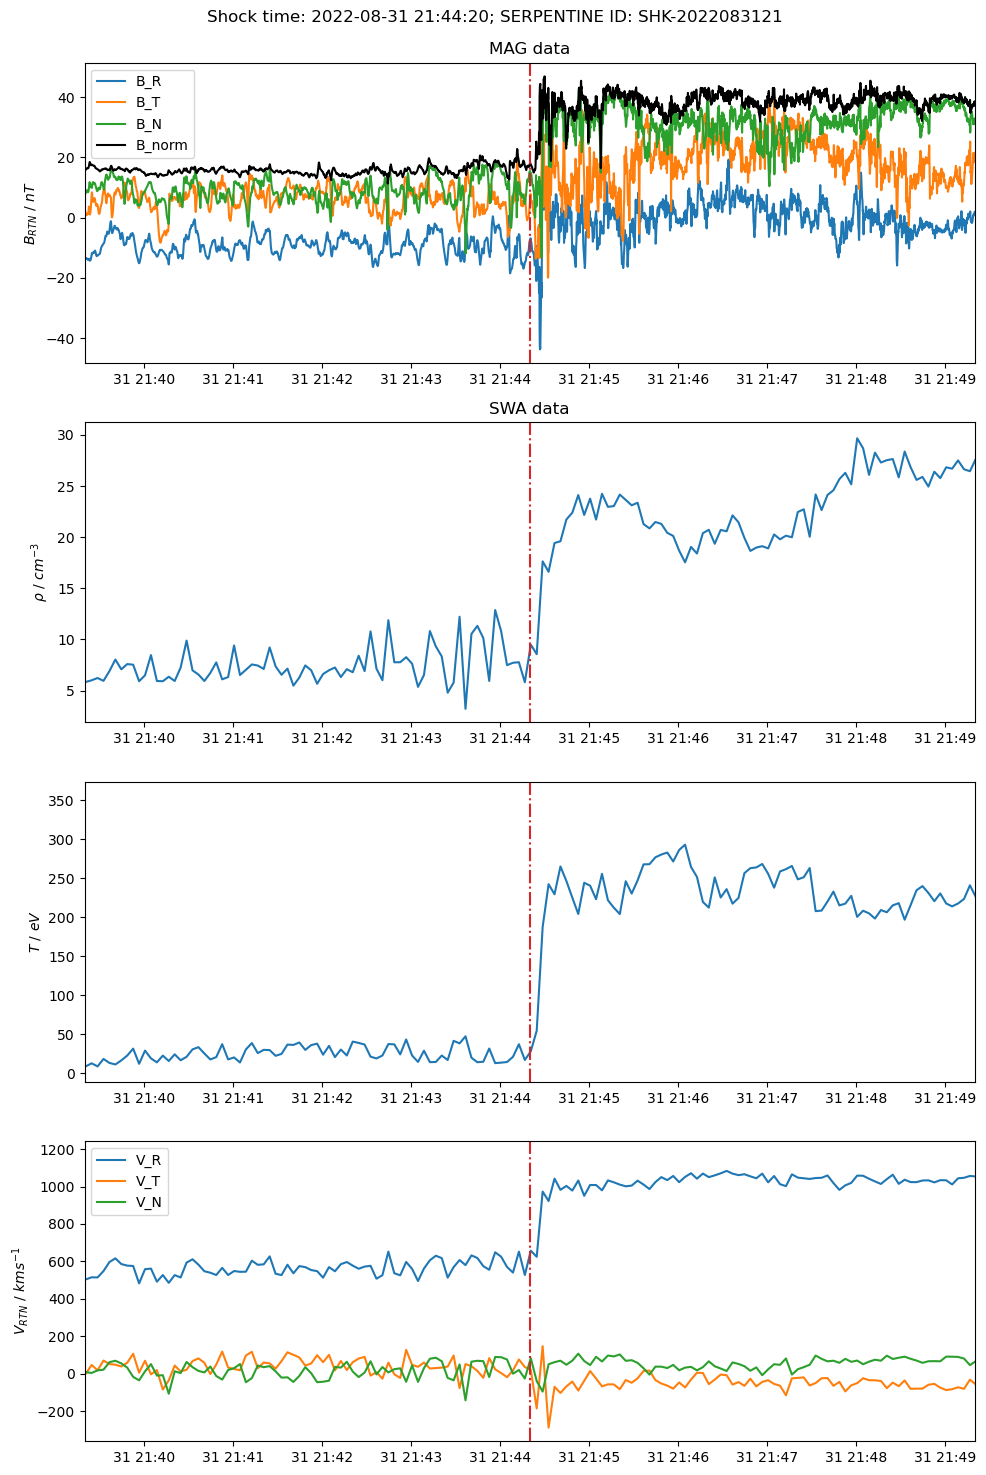

In [9]:
fig, ax = plt.subplots(4, 1, figsize=(10, 15))

B_norm = [np.linalg.norm(data_MAG.B_RTN.data[i]) for i in range(data_MAG.sizes["EPOCH"])]

fig.suptitle("Shock time: "+shock_datetime+"; SERPENTINE ID: "+shock_id+"\n")

ax[0].set_title("MAG data")
ax[0].plot(data_MAG.EPOCH, data_MAG.B_RTN[:, 0], c="tab:blue", label="B_R")
ax[0].plot(data_MAG.EPOCH, data_MAG.B_RTN[:, 1], c="tab:orange", label="B_T")
ax[0].plot(data_MAG.EPOCH, data_MAG.B_RTN[:, 2], c="tab:green", label="B_N")
ax[0].plot(data_MAG.EPOCH, B_norm, c="k", label="B_norm")
ax[0].set_ylabel(r"$B_{RTN}~/~nT$")
ax[0].legend()

ax[1].set_title("SWA data")
ax[1].plot(data_SWA.Epoch, data_SWA.N)
ax[1].set_ylabel(r"$\rho~/~cm^{-3}$")

ax[2].plot(data_SWA.Epoch, data_SWA.T)
ax[2].set_ylabel(r"$T~/~eV$")

ax[3].plot(data_SWA.Epoch, data_SWA.V_RTN[:, 0], c="tab:blue", label="V_R")
ax[3].plot(data_SWA.Epoch, data_SWA.V_RTN[:, 1], c="tab:orange", label="V_T")
ax[3].plot(data_SWA.Epoch, data_SWA.V_RTN[:, 2], c="tab:green", label="V_N")
ax[3].set_ylabel(r"$V_{RTN}~/~kms^{-1}$")
ax[3].legend()

for axi in ax:
    axi.axvline(pd.to_datetime(shock_datetime), c="tab:red", ls="-.")
    axi.set_xlim(pd.to_datetime(shock_datetime)-pd.Timedelta(5, "min"),
                 pd.to_datetime(shock_datetime)+pd.Timedelta(5, "min"))

plt.tight_layout()

# 4. Obtaining 20 Pairs of the Shock Normal Vector $\hat{n}$ and Shock Speed in the Spacecraft Frame $V_{sh}^{sc}$ with SerPyShock

In [10]:
buffer_up = dt.timedelta(minutes = .5)
buffer_down = dt.timedelta(minutes = .5)

min_window_up = dt.timedelta(minutes = 1)
max_window_up = dt.timedelta(minutes = 5)
min_window_down = dt.timedelta(minutes = 1)
max_window_down = dt.timedelta(minutes = 5)

cadence = dt.timedelta(seconds=5)

In [11]:
shock_time = pd.to_datetime(shock_datetime)

end_time_up  = shock_time  - buffer_up
start_time_up = end_time_up  - max_window_up

start_time_down  = shock_time  + buffer_down
end_time_down = start_time_down  + max_window_down

In [12]:
B = data_MAG.B_RTN.values
B_times = np.array(data_MAG.EPOCH.values, dtype="datetime64[ns]")

V = data_SWA.V_RTN.values
Rho = data_SWA.N.values
Tp = data_SWA.T.values
mom_times = np.array(data_SWA.Epoch.values, dtype="datetime64[ns]")

coord = "RTN"

## 4.1. Laura's Code from Here Onwards (with Adaptations)

In [13]:
B_times_float = B_times.astype("float")
mom_times_float = mom_times.astype("float")
Tp_interp = np.interp(B_times_float, mom_times_float, Tp)
Rho_interp = np.interp(B_times_float, mom_times_float, Rho)
beta = 2*4*np.pi*10**(-7)*Rho_interp*10**6*Tp_interp*1.602*10**(-19)/((np.linalg.norm(B,axis=1)*10**(-9))**2)

In [14]:
B_vec_up, B_vec_down, V_vec_up, V_vec_down, Rho_up, Rho_down, beta_up, beta_down = SerPyShock_LauraVersion.window_parameters(B_times, B, mom_times, V, mom_times, Rho, mom_times, beta, shock_time, end_time_up, start_time_down, min_window_up, max_window_up, min_window_down, max_window_down, cadence)

Upstream windows = 0 / 48
Upstream windows = 1 / 48
Upstream windows = 2 / 48
Upstream windows = 3 / 48
Upstream windows = 4 / 48
Upstream windows = 5 / 48
Upstream windows = 6 / 48
Upstream windows = 7 / 48
Upstream windows = 8 / 48
Upstream windows = 9 / 48
Upstream windows = 10 / 48
Upstream windows = 11 / 48
Upstream windows = 12 / 48
Upstream windows = 13 / 48
Upstream windows = 14 / 48
Upstream windows = 15 / 48
Upstream windows = 16 / 48
Upstream windows = 17 / 48
Upstream windows = 18 / 48
Upstream windows = 19 / 48
Upstream windows = 20 / 48
Upstream windows = 21 / 48
Upstream windows = 22 / 48
Upstream windows = 23 / 48
Upstream windows = 24 / 48
Upstream windows = 25 / 48
Upstream windows = 26 / 48
Upstream windows = 27 / 48
Upstream windows = 28 / 48
Upstream windows = 29 / 48
Upstream windows = 30 / 48
Upstream windows = 31 / 48
Upstream windows = 32 / 48
Upstream windows = 33 / 48
Upstream windows = 34 / 48
Upstream windows = 35 / 48
Upstream windows = 36 / 48
Upstream wi

In [15]:
def mixed_mode_normals(B_up_vec, B_down_vec, V_up_vec, V_down_vec):
    """
    Calculates the three mixed-mode shock normal vectors using
    averaged B and V vectors in the upstream and downstream
    windows.
    """
    dif_B = B_down_vec - B_up_vec
    dif_V = V_down_vec - V_up_vec
    normal1 = np.cross(np.cross(B_up_vec,dif_V),dif_B)
    normal1 = normal1 / np.linalg.norm(normal1)
    normal2 = np.cross(np.cross(B_down_vec,dif_V),dif_B)
    normal2 = normal2 / np.linalg.norm(normal2)
    normal3 = np.cross(np.cross(dif_B,dif_V),dif_B)
    normal3 = normal3 / np.linalg.norm(normal3)
    return np.array([normal1,normal2,normal3])

def mass_flux_algorithm(n_up, n_down, V_up_vec, V_down_vec,shock_normal):
    """
    Calculates the shock speed in spacecraft frame using the conservation
    of mass flux across the shock.
    """
    flux_down = n_down*V_down_vec
    flux_up = n_up*V_up_vec
    flux_dif = flux_down-flux_up
    n_dif = n_down - n_up
    shock_speed = np.dot(flux_dif,shock_normal)/n_dif
    return shock_speed

In [16]:
#Gather shock parameters for all the upstream and downstream window pairs.
#param_arr3: Using the 3rd mixed mode normal

shock_normals_MX3 = []
shock_speeds = []

for i in range(len(Rho_up)):
    #The mixed-mode normals
    normals = mixed_mode_normals(B_vec_up[i,:], B_vec_down[i,:], V_vec_up[i,:], V_vec_down[i,:])
    n1 = normals[0]
    n2 = normals[1]
    n3 = normals[2]

    #Calculate the average of the vectors (check the signs!)
    n_avg = n3
    if n_avg[0]<0:
        n_avg *= -1

    #Estimating shock speed along the normal vector
    shock_normal = n_avg #Check normal sign!
    shock_speed = mass_flux_algorithm(Rho_up[i], Rho_down[i], V_vec_up[i,:], V_vec_down[i,:],shock_normal)
    
    shock_normals_MX3.append(shock_normal)
    shock_speeds.append(shock_speed)

shock_normals_MX3 = np.array(shock_normals_MX3)
shock_speeds = np.array(shock_speeds)

In [17]:
random_pair_idx = np.random.randint(low=0, high=shock_normals_MX3.shape[0], size=20)

shock_normals_20 = shock_normals_MX3[random_pair_idx, :]
shock_speeds_20 = shock_speeds[random_pair_idx]

# 5. Calculating the Shock Velocity Ratio $-V_{sh}^{sc}\,ratio$ and Dynamic Pressure Ratios in the Shock Frame $P_{dyn,\,n}^{sh}\,ratio$

In [18]:
V_ratios = []
V_ratios_up = []
V_ratios_down = []

for i in range(20):
    shock_normal_i = shock_normals_20[i]
    shock_speed_i = shock_speeds_20[i]

    V_rtn_shockFrame = V - np.dot(shock_normal_i, shock_speed_i)
    V_n_shockFrame = np.dot(V_rtn_shockFrame, shock_normal_i)

    V_n_shockFrame = pd.DataFrame(V_n_shockFrame, index=mom_times)
    V_n_shockFrame_up = V_n_shockFrame.loc[pd.to_datetime(start_time_up):pd.to_datetime(end_time_up)].mean()
    V_n_shockFrame_down = V_n_shockFrame.loc[pd.to_datetime(start_time_down):pd.to_datetime(end_time_down)].mean()

    V_ratio = -V_n_shockFrame/V_n_shockFrame_up
    V_ratios.append(V_ratio)

    V_ratio_up = V_ratio.loc[pd.to_datetime(start_time_up):pd.to_datetime(end_time_up)].mean()
    V_ratios_up.append(V_ratio_up)

    V_ratio_down = V_ratio.loc[pd.to_datetime(start_time_down):pd.to_datetime(end_time_down)].mean()
    V_ratios_down.append(V_ratio_down)

In [19]:
P_ratios = []
P_ratios_up = []
P_ratios_down = []

for i in range(20):
    shock_normal_i = shock_normals_20[i]
    shock_speed_i = shock_speeds_20[i]

    V_rtn_shockFrame = V - np.dot(shock_normal_i, shock_speed_i)
    V_n_shockFrame = np.dot(V_rtn_shockFrame, shock_normal_i)
    
    P_dyn_n = Rho * V_n_shockFrame**2

    P_dyn_n = pd.DataFrame(P_dyn_n, index=mom_times)
    P_dyn_n_up = P_dyn_n.loc[pd.to_datetime(start_time_up):pd.to_datetime(end_time_up)].mean()

    P_ratio = P_dyn_n/P_dyn_n_up
    P_ratios.append(P_ratio)

    P_ratio_up = P_ratio.loc[pd.to_datetime(start_time_up):pd.to_datetime(end_time_up)].mean()
    P_ratios_up.append(P_ratio_up)

    P_ratio_down = P_ratio.loc[pd.to_datetime(start_time_down):pd.to_datetime(end_time_down)].mean()
    P_ratios_down.append(P_ratio_down)

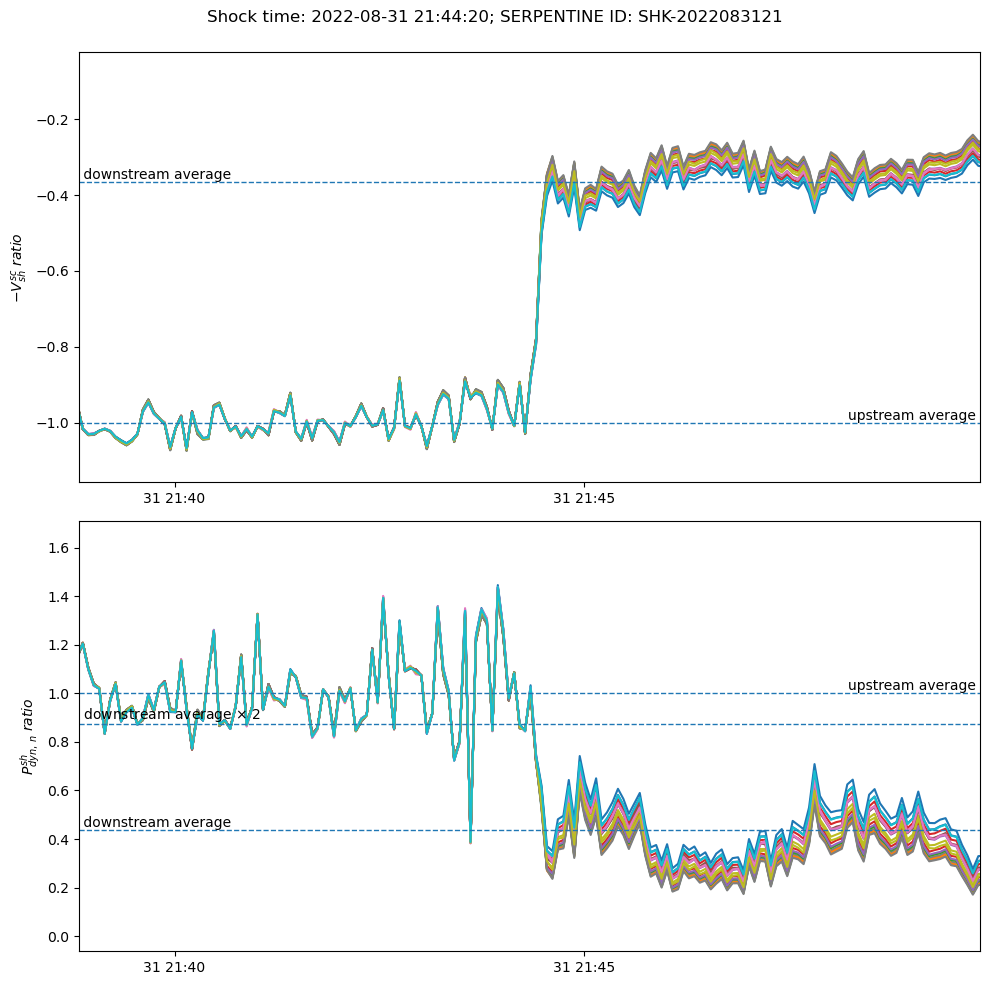

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

fig.suptitle("Shock time: "+shock_datetime+"; SERPENTINE ID: "+shock_id+"\n")

for i in range(20):
    ax[0].plot(V_ratios[i])
    ax[1].plot(P_ratios[i])

ax[0].axhline(np.mean(V_ratio_up), ls="--", lw=1)
ax[0].axhline(np.mean(V_ratio_down), ls="--", lw=1)
ax[0].text(pd.to_datetime(end_time_down), np.mean(V_ratio_up), r"upstream average ", ha='right', va='bottom')
ax[0].text(pd.to_datetime(start_time_up), np.mean(V_ratio_down), r" downstream average", ha='left', va='bottom')
ax[0].set_ylabel(r"$-V_{sh}^{sc}~ratio$")

ax[1].axhline(np.mean(P_ratio_up), ls="--", lw=1)
ax[1].axhline(np.mean(P_ratio_down), ls="--", lw=1)
ax[1].axhline(2*np.mean(P_ratio_down), ls="--", lw=1)
ax[1].text(pd.to_datetime(end_time_down), np.mean(P_ratio_up), r"upstream average ", ha='right', va='bottom')
ax[1].text(pd.to_datetime(start_time_up), np.mean(P_ratio_down), r" downstream average", ha='left', va='bottom')
ax[1].text(pd.to_datetime(start_time_up), 2*np.mean(P_ratio_down), r" downstream average $\times$ 2", ha='left', va='bottom')
ax[1].set_ylabel(r"$P_{dyn,\,n}^{sh}~ratio$")

ax[0].set_xlim(pd.to_datetime(start_time_up), pd.to_datetime(end_time_down))
ax[1].set_xlim(pd.to_datetime(start_time_up), pd.to_datetime(end_time_down))

plt.tight_layout()

# 6. Making the Final Stack Plot

In [21]:
ustart_dt = pd.to_datetime(start_time_up)
uend_dt = pd.to_datetime(end_time_up)
dstart_dt = pd.to_datetime(start_time_down)
dend_dt = pd.to_datetime(end_time_down)
shock_dt = pd.to_datetime(shock_datetime)

B = pd.DataFrame(B_norm, index=data_MAG.EPOCH)
B_down = B.loc[dstart_dt:dend_dt].mean()[0]
Rho_down = pd.DataFrame(data_SWA.N, index=data_SWA.Epoch).loc[dstart_dt:dend_dt].mean()[0]

purple_hex_colors = ["#800080", "#8A2BE2", "#9370DB", "#BA55D3", "#DA70D6",
                     "#D8BFD8", "#DDA0DD", "#EE82EE", "#FF00FF", "#9932CC",
                     "#9400D3", "#6A0DAD", "#7B68EE", "#4B0082", "#6A5ACD",
                     "#C71585", "#DB7093", "#E6E6FA", "#A020F0", "#B57EDC"]

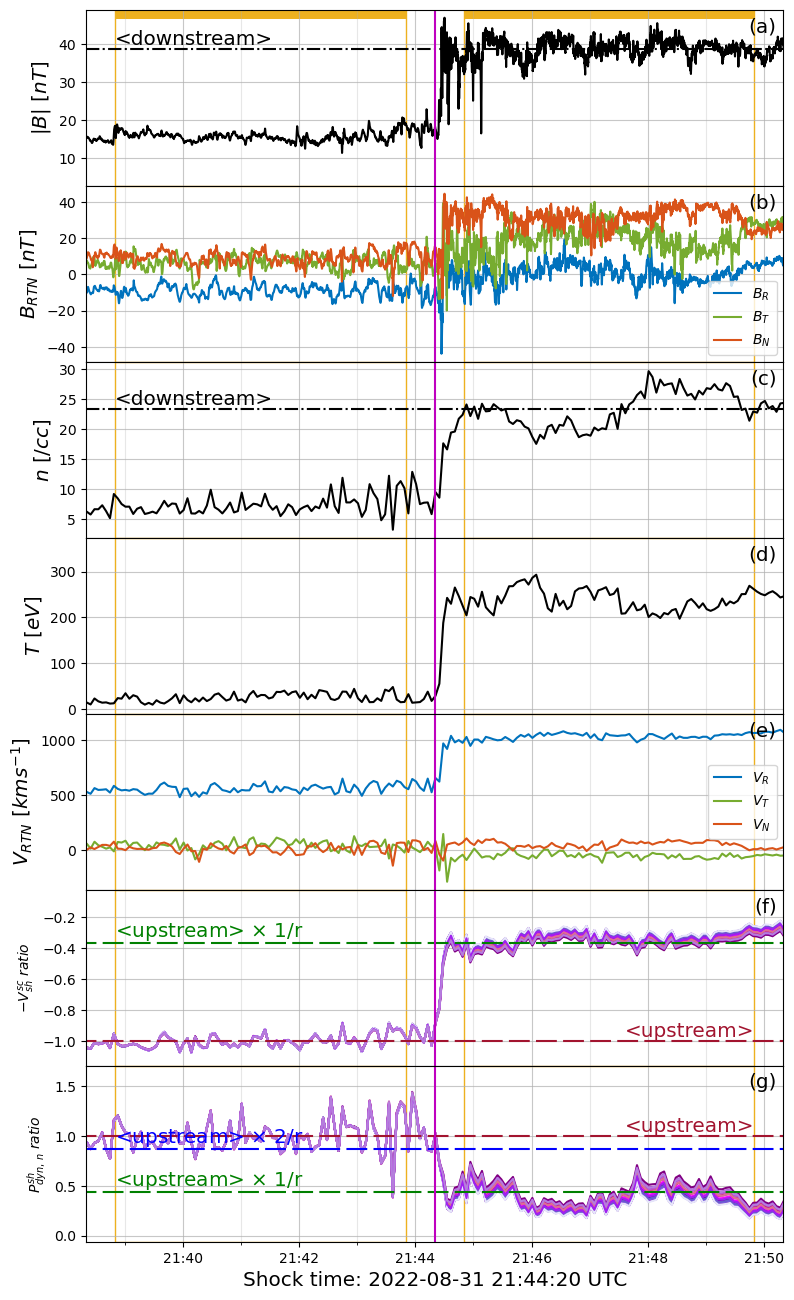

In [23]:
fig, ax = plt.subplots(7, 1, figsize=(9, 16), sharex=True)
fig.subplots_adjust(hspace=0)

ax[0].xaxis.set_major_locator(mdates.MinuteLocator(byminute=None, interval=2, tz=None))
ax[0].xaxis.set_minor_locator(mdates.MinuteLocator(byminute=None, interval=1, tz=None))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

ax[0].plot(B, lw=1.5, c="k")
ax[0].axhline(B_down, lw=1.5, ls="-.", c="k")
ax[0].text(ustart_dt, B_down, "<downstream>", ha='left', va='bottom', c="k", size="x-large")
ax[0].set_ylabel("$|B|~[nT]$", size="x-large")
ax[0].text(0.99, 0.96, "(a)", ha="right", va="top", c="k", size="x-large", transform = ax[0].transAxes)
ylim_dn, ylim_up = ax[0].get_ylim()
ax[0].set_ylim(ylim_dn, ylim_up)

ax[1].plot(data_MAG.EPOCH, data_MAG.B_RTN[:, 0], c="#0072BD", label="$B_R$")
ax[1].plot(data_MAG.EPOCH, data_MAG.B_RTN[:, 1], c="#77AC30", label="$B_T$")
ax[1].plot(data_MAG.EPOCH, data_MAG.B_RTN[:, 2], c="#D95319", label="$B_N$")
ax[1].set_ylabel("$B_{RTN}~[nT]$", size="x-large")
ax[1].text(0.99, 0.96, "(b)", ha="right", va="top", c="k", size="x-large", transform = ax[1].transAxes)
ax[1].legend()

ax[2].plot(data_SWA.Epoch, data_SWA.N, lw=1.5, c="k")
ax[2].axhline(Rho_down, lw=1.5, ls="-.", c="k")
ax[2].text(ustart_dt, Rho_down, "<downstream>", ha='left', va='bottom', c="k", size="x-large")
ax[2].set_ylabel("$n~[/cc]$", size="x-large")
ax[2].text(0.99, 0.96, "(c)", ha="right", va="top", c="k", size="x-large", transform = ax[2].transAxes)

ax[3].plot(data_SWA.Epoch, data_SWA.T, lw=1.5, c="k")
ax[3].set_ylabel("$T~[eV]$", size="x-large")
ax[3].text(0.99, 0.96, "(d)", ha="right", va="top", c="k", size="x-large", transform = ax[3].transAxes)

ax[4].plot(data_SWA.Epoch, data_SWA.V_RTN[:, 0], lw=1.5, c="#0072BD", label="$V_R$")
ax[4].plot(data_SWA.Epoch, data_SWA.V_RTN[:, 1], lw=1.5, c="#77AC30", label="$V_T$")
ax[4].plot(data_SWA.Epoch, data_SWA.V_RTN[:, 2], lw=1.5, c="#D95319", label="$V_N$")
ax[4].set_ylabel("$V_{RTN}~[km s^{-1}]$", size="x-large")
ax[4].text(0.99, 0.96, "(e)", ha="right", va="top", c="k", size="x-large", transform = ax[4].transAxes)
ax[4].legend()

for i in range(20):
    ax[5].plot(V_ratios[i], c=purple_hex_colors[i])
    ax[6].plot(P_ratios[i], c=purple_hex_colors[i])

ax[5].axhline(np.mean(V_ratio_up), ls=(5, (10, 3)), lw=1.5, c="#A2142F")
ax[5].axhline(np.mean(V_ratio_down), ls=(5, (10, 3)), lw=1.5, c="green")
ax[5].text(dend_dt, np.mean(V_ratio_up), "<upstream>", ha='right', va='bottom', c="#A2142F", size="x-large")
ax[5].text(ustart_dt, np.mean(V_ratio_down), r"<upstream> $\times$ 1/r", ha='left', va='bottom', c="green", size="x-large")
ax[5].text(0.99, 0.96, "(f)", ha="right", va="top", c="k", size="x-large", transform = ax[5].transAxes)
ax[5].set_ylabel(r"$-V_{sh}^{sc}~ratio$")

ax[6].axhline(np.mean(P_ratio_up), ls=(5, (10, 3)), lw=1.5, c="#A2142F")
ax[6].axhline(np.mean(P_ratio_down), ls=(5, (10, 3)), lw=1.5, c="green")
ax[6].axhline(2*np.mean(P_ratio_down), ls=(5, (10, 3)), lw=1.5, c="blue")
ax[6].text(dend_dt, np.mean(P_ratio_up), r"<upstream>", ha='right', va='bottom', c="#A2142F", size="x-large")
ax[6].text(ustart_dt, np.mean(P_ratio_down), r"<upstream> $\times$ 1/r", ha='left', va='bottom', c="green", size="x-large")
ax[6].text(ustart_dt, 2*np.mean(P_ratio_down), r"<upstream> $\times$ 2/r", ha='left', va='bottom', c="blue", size="x-large")
ax[6].text(0.99, 0.96, "(g)", ha="right", va="top", c="k", size="x-large", transform = ax[6].transAxes)
ax[6].set_ylabel(r"$P_{dyn,\,n}^{sh}~ratio$")

plt.xlim(ustart_dt-pd.Timedelta(30, "s"), dend_dt+pd.Timedelta(30, "s"))
ax[-1].set_xlabel("Shock time: "+shock_datetime+" UTC", size="x-large")

for i in range(7):
    # ax[i].axvspan(uend_dt - pd.Timedelta(min_window_up), uend_dt, facecolor="b", alpha=0.2)
    # ax[i].axvspan(uend_dt - pd.Timedelta(max_window_up), uend_dt, facecolor="b", alpha=0.2)
    # ax[i].axvspan(dstart_dt, dstart_dt + pd.Timedelta(min_window_down), facecolor="r", alpha=0.2)
    # ax[i].axvspan(dstart_dt, dstart_dt + pd.Timedelta(max_window_down), facecolor="r", alpha=0.2)
    
    ax[i].axvline(x=shock_dt, color="m")
    ax[i].axvspan(ustart_dt, uend_dt, edgecolor="#EDB120", facecolor="None")
    ax[i].axvspan(dstart_dt, dend_dt, edgecolor="#EDB120", facecolor="None")
    ax[i].grid(which="minor", alpha=0.3)
    ax[i].grid(which="major", alpha=0.7)

ax[0].broken_barh([(ustart_dt, uend_dt-ustart_dt), (dstart_dt, dend_dt-dstart_dt)],
                      (ylim_up*.95, ylim_up*.1), facecolors="#EDB120")

# for i in range(7):
#     ax[i].axvspan(pd.to_datetime("2022-06-17 00:41:43"),
#                   pd.to_datetime("2022-06-17 00:41:48"),
#                   facecolor="blue", alpha=0.3)

# plt.savefig("SHK-2022083121-dyn-ratio.jpeg")